In [ ]:
# !pip -q install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
#!pip install segmentation_models_pytorch

In [1]:
# libraries
import os
import time
import subprocess
import numpy as np
import pandas as pd
import ast
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from tqdm import tqdm_notebook as tqdm

scaler = amp.GradScaler()
device = torch.device('cuda')

In [3]:
kernel_type = 'GAN'
enet_type = 'timm-efficientnet-b6'
data_dir = '../../xray_images'
num_workers = 8
image_size = 256
batch_size = 8
init_lr = 1e-4
warmup_epo = 1
cosine_epo = 25
n_epochs = warmup_epo + cosine_epo
use_amp = True
image_folder = 'train'

log_dir = 'logs_GAN'
model_dir = 'models_GAN'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
log_file = os.path.join(log_dir, f'log_{kernel_type}.txt')


In [4]:
train_df = pd.read_csv(os.path.join(data_dir,'train.csv')).drop('PatientID', axis=1)
train_df.shape

(30083, 12)

In [5]:
train_df_annotations = pd.read_csv(os.path.join(data_dir,'train_annotations.csv'))
train_df_annotations.shape

(17999, 3)

In [6]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),                                    
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.75),
    albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=int(image_size * 0.3), max_w_size=int(image_size * 0.3), num_holes=1, p=0.75),
])
transforms_val = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [7]:
class XrayDataset(Dataset):

    def __init__(self,df, mode, transform=None):

        self.df = df
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(data_dir, image_folder, self.df[index] + '.jpg'))[:, :, ::-1]
        
        if self.mode == 'test':
            mask = None
            res = self.transform(image=image)
        else:
            df_this = train_df_annotations.query(f'StudyInstanceUID == "{self.df[index]}"')
            mask = np.zeros((image.shape[0], image.shape[1], 1)).astype(np.uint8)
            for _, anno in df_this.iterrows():
                anno_this = np.array(ast.literal_eval(anno["data"]))
                mask1 = mask[:,:,0].copy()
                mask1 = cv2.polylines(mask1, np.int32([anno_this]), isClosed=False, color=1, thickness=15, lineType=16)
                mask[:, :, 0] = mask1
            mask = (mask > 0.5).astype(np.uint8)
            res = self.transform(image=image, mask=mask)
            
        image = res['image'].astype(np.float32).transpose(2, 0, 1) / 255.

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            mask = res['mask'].astype(np.float32)
            mask = mask.transpose(2, 0, 1).clip(0,1)
            return torch.tensor(image), torch.tensor(mask)

In [8]:
train_files = train_df_annotations['StudyInstanceUID'].unique()
len(train_files)

9095

In [9]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(8, 8))
    for i, (name, image) in enumerate(images.items()):
        if image.shape[0] == 3:
            image = image.numpy()
            image = image.transpose((1,2,0))
        elif image.shape[0] == 1:
            image = image.numpy()
            image = image.reshape(image.shape[1],image.shape[2])
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    #plt.savefig(time.ctime()+'.png')
    plt.show()

In [10]:
dataset_show = XrayDataset(train_files,'train', transform=transforms_train)

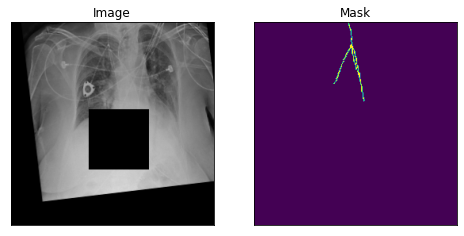

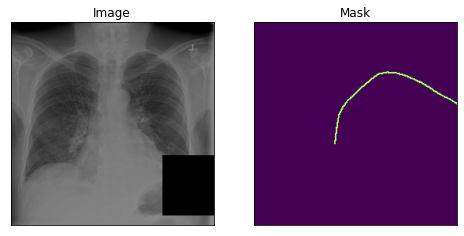

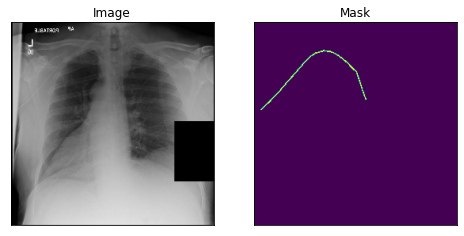

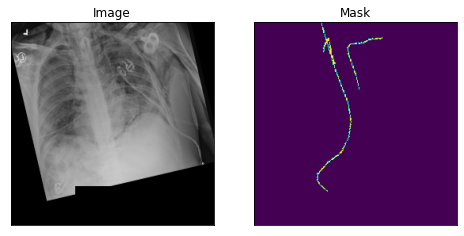

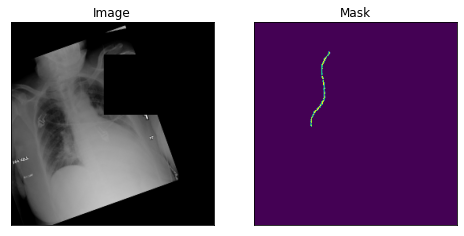

In [11]:
# visualizing some training data with augmentations implied
for i in range(5):
    image, mask = dataset_show[i]
    visualize(image=image, mask=mask)

In [12]:
# class SegmentationModel(nn.Module):
#     def __init__(self, backbone):
#         super(SegmentationModel, self).__init__()
#         self.seg = smp.UnetPlusPlus(encoder_name=backbone, encoder_weights='imagenet', classes=1, activation=None)
#     def forward(self,x):
#         global_features = self.seg.encoder(x)
#         seg_features = self.seg.decoder(*global_features)
#         seg_features = self.seg.segmentation_head(seg_features)
#         return seg_features


In [13]:
class SegmentationModel(nn.Module):
    def __init__(self, backbone):
        super(SegmentationModel, self).__init__()
        self.seg = smp.DeepLabV3Plus(encoder_name=backbone, encoder_weights='imagenet', classes=1, activation=None)
    def forward(self,x):
        global_features = self.seg.encoder(x)
        seg_features = self.seg.decoder(*global_features)
        seg_features = self.seg.segmentation_head(seg_features)
        return seg_features

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
                
        self.structure = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False)
        )
        
    def forward(self, x):
        return self.structure(x)

In [16]:
def dice_loss(input,target):
    num=input*target
    num=torch.sum(num,dim=2)
    num=torch.sum(num,dim=2)

    den1=input*input
    den1=torch.sum(den1,dim=2)
    den1=torch.sum(den1,dim=2)

    den2=target*target
    den2=torch.sum(den2,dim=2)
    den2=torch.sum(den2,dim=2)

    dice=2*(num/(den1+den2))

    dice_total=1-1*torch.sum(dice)/dice.size(0)#divide by batchsize

    return dice_total

In [17]:
def train_epoch(modelG, modelD, loader, optimizerG,optimizerD):

    modelG.train()
    modelD.train()
    trainG_loss = []
    trainD_loss = []
    bar = tqdm(loader)
    for (data, mask) in bar:
        #Train Discriminator
        optimizerD.zero_grad()
        data, mask = data.to(device), mask.to(device)
        real_data = torch.cat([data, mask], dim=1).to(device)
        
        #Real data
        outputs = modelD(real_data) # label "real" data
        labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
        lossD_real = criterion(outputs, labels) # divide the objective by 2 -> slow down D
              
        #Fake Data
        gens = modelG(data).detach()
        fake_data = torch.cat([data, gens], dim=1) # generated image data
        
        outputs = modelD(fake_data)
        labels = torch.zeros(size = outputs.shape, dtype=torch.float, device=device) # label "fake" data
        lossD_fake = criterion(outputs, labels) # divide the objective by 2 -> slow down D
        #lossD_fake.backward()
        lossD = (lossD_fake + lossD_real) * 0.5
        lossD.backward()
        optimizerD.step()
        trainD_loss.append(lossD.item())
        
        #Train Generator
        optimizerG.zero_grad()
        with amp.autocast():
            gens = modelG(data)
            gen_data = torch.cat([data, gens], dim=1)
            with torch.no_grad():
                outputs = modelD(gen_data)
            labels = torch.ones(size = outputs.shape, dtype=torch.float, device=device)
            loss = criterion(outputs, labels)*0.5 + criterion(gens,mask)*0.5# dice_loss(gens.sigmoid(),mask)L1_lambda * torch.abs(gens-mask).sum()
        scaler.scale(loss).backward()
        scaler.step(optimizerG)
        scaler.update()

        loss_np = loss.item()
        trainG_loss.append(loss_np)
        smooth_loss = sum(trainG_loss[-50:]) / min(len(trainG_loss), 50)
        bar.set_description('loss: %.4f, smth: %.4f' % (loss_np, smooth_loss))

    return np.mean(trainG_loss),np.mean(trainD_loss)

In [18]:
def valid_epoch(model, loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    with torch.no_grad():
        for (data, mask) in tqdm(loader):
            data, mask = data.to(device), mask.to(device)
            logits = model(data)
            loss = criterion(logits, mask)
            val_loss.append(loss.item())
            LOGITS.append(logits.cpu())

    if get_output:
        LOGITS = torch.cat(LOGITS, 0).float().sigmoid()
        return LOGITS
    else:
        val_loss = np.mean(val_loss)
        return val_loss

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_val = train_test_split(train_files,random_state = 42, test_size = 0.2)

In [20]:
print(len(X_train),len(X_val))

7276 1819


In [21]:
def weights_init(m):
    name = m.__class__.__name__
    
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02) # ~N(mean=0.0, std=0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [22]:
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.L1Loss()

In [23]:
batch_size

8

Fri Jun 25 22:22:39 2021 Epoch: 27


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 22:33:16 2021 Epoch 27,lrG: 0.0000000, lrD: 0.0000000 trainG loss: 9.11290,trainD loss: 0.00000, valid loss: 0.01845.


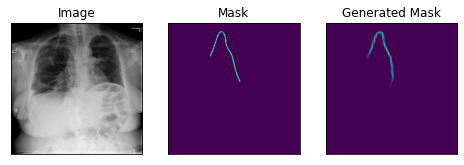

Fri Jun 25 22:33:21 2021 Epoch: 28


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 22:43:57 2021 Epoch 28,lrG: 0.0000039, lrD: 0.0000039 trainG loss: 9.12751,trainD loss: 0.00000, valid loss: 0.01844.


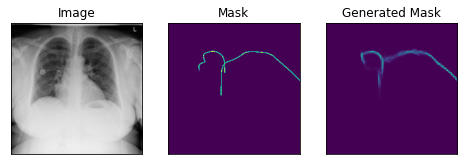

Fri Jun 25 22:44:02 2021 Epoch: 29


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 22:54:39 2021 Epoch 29,lrG: 0.0000157, lrD: 0.0000157 trainG loss: 9.21699,trainD loss: 0.00000, valid loss: 0.01844.


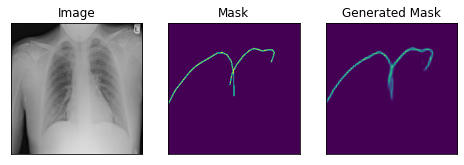

Fri Jun 25 22:54:44 2021 Epoch: 30


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:05:20 2021 Epoch 30,lrG: 0.0000351, lrD: 0.0000351 trainG loss: 9.43438,trainD loss: 0.00000, valid loss: 0.01839.


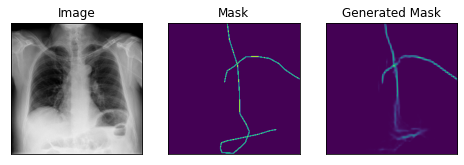

Validation loss decreased (0.018402 --> 0.018388).  Saving model ...
Fri Jun 25 23:05:26 2021 Epoch: 31


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:16:02 2021 Epoch 31,lrG: 0.0000618, lrD: 0.0000618 trainG loss: 9.75793,trainD loss: 0.00000, valid loss: 0.01847.


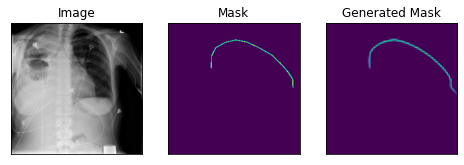

Fri Jun 25 23:16:08 2021 Epoch: 32


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:26:45 2021 Epoch 32,lrG: 0.0000955, lrD: 0.0000955 trainG loss: 10.14233,trainD loss: 0.00000, valid loss: 0.01851.


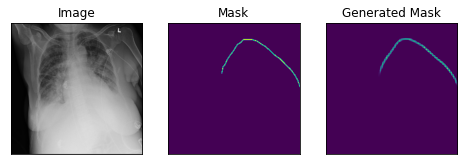

Fri Jun 25 23:26:50 2021 Epoch: 33


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:37:28 2021 Epoch 33,lrG: 0.0001355, lrD: 0.0001355 trainG loss: 10.46431,trainD loss: 0.00000, valid loss: 0.01871.


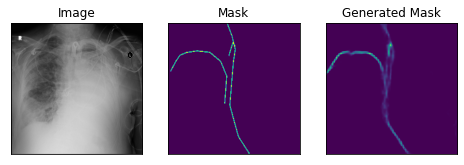

Fri Jun 25 23:37:33 2021 Epoch: 34


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:48:10 2021 Epoch 34,lrG: 0.0001813, lrD: 0.0001813 trainG loss: 10.77432,trainD loss: 0.00000, valid loss: 0.01861.


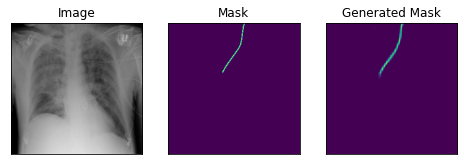

Fri Jun 25 23:48:15 2021 Epoch: 35


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Fri Jun 25 23:58:52 2021 Epoch 35,lrG: 0.0002321, lrD: 0.0002321 trainG loss: 10.96031,trainD loss: 0.00000, valid loss: 0.01870.


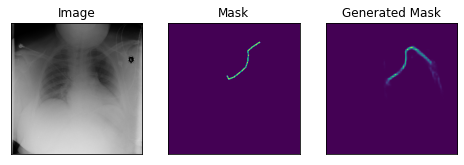

Fri Jun 25 23:58:57 2021 Epoch: 36


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Sat Jun 26 00:09:33 2021 Epoch 36,lrG: 0.0002871, lrD: 0.0002871 trainG loss: 11.23828,trainD loss: 0.00000, valid loss: 0.01888.


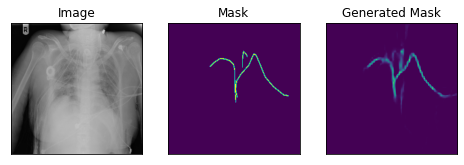

Sat Jun 26 00:09:38 2021 Epoch: 37


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Sat Jun 26 00:20:15 2021 Epoch 37,lrG: 0.0003455, lrD: 0.0003455 trainG loss: 11.45738,trainD loss: 0.00000, valid loss: 0.01871.


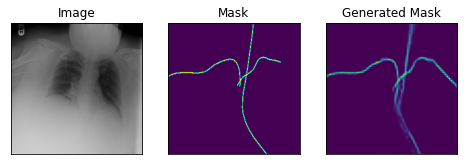

Sat Jun 26 00:20:20 2021 Epoch: 38


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Sat Jun 26 00:30:56 2021 Epoch 38,lrG: 0.0004063, lrD: 0.0004063 trainG loss: 11.64865,trainD loss: 0.00000, valid loss: 0.01889.


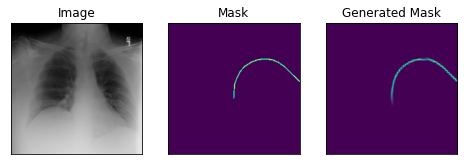

Sat Jun 26 00:31:01 2021 Epoch: 39


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Sat Jun 26 00:41:38 2021 Epoch 39,lrG: 0.0004686, lrD: 0.0004686 trainG loss: 11.81351,trainD loss: 0.00000, valid loss: 0.01917.


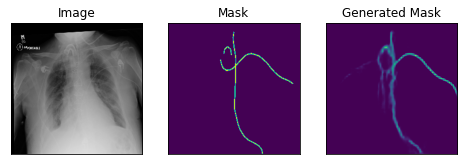

Sat Jun 26 00:41:43 2021 Epoch: 40


  0%|          | 0/910 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

Sat Jun 26 00:52:20 2021 Epoch 40,lrG: 0.0005314, lrD: 0.0005314 trainG loss: 11.92286,trainD loss: 0.00000, valid loss: 0.01882.


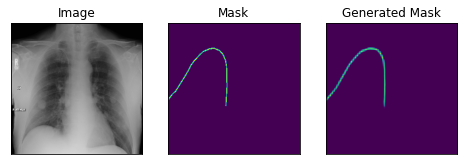

In [37]:
# content = ''
# print(content)
# with open(log_file, 'a') as appender:
#     appender.write(content + '\n')

# dataset_train = XrayDataset(X_train, 'train', transform=transforms_train)
# dataset_valid = XrayDataset(X_val, 'valid', transform=transforms_val)
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# sig = nn.Sigmoid()

# modelG = SegmentationModel(enet_type)
# modelG = modelG.to(device)
# val_loss_min = np.Inf

# modelD = Discriminator()
# modelD.apply(weights_init)
# modelD = modelD.to(device)

# optimizerD = optim.Adam(modelD.parameters(), lr=init_lr)
# schedulerD_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD, cosine_epo)
# schedulerD_warmup = GradualWarmupSchedulerV2(optimizerD, multiplier=10, total_epoch=warmup_epo, after_scheduler=schedulerD_cosine)

# optimizerG = optim.Adam(modelG.parameters(), lr=init_lr)
# schedulerG_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, cosine_epo)
# schedulerG_warmup = GradualWarmupSchedulerV2(optimizerG, multiplier=10, total_epoch=warmup_epo, after_scheduler=schedulerG_cosine)
for epoch in range(27, 40+1):
    print(time.ctime(), 'Epoch:', epoch)
    schedulerD_warmup.step(epoch-1)
    schedulerG_warmup.step(epoch-1)
    trainG_loss,trainD_loss = train_epoch(modelG,modelD, train_loader, optimizerG,optimizerD)
    val_loss = valid_epoch(modelG, valid_loader)

    content = time.ctime() + ' ' +\
                f'Epoch {epoch},lrG: {optimizerG.param_groups[0]["lr"]:.7f}, lrD: {optimizerD.param_groups[0]["lr"]:.7f} '+\
                f'trainG loss: {trainG_loss:.5f},trainD loss: {trainD_loss:.5f}, valid loss: {(val_loss):.5f}.'
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')
    with torch.no_grad():
        k = np.random.randint(0,len(dataset_valid))
        img,mask = dataset_valid[k]
        x_tensor = img.to(device).unsqueeze(0)
        pr_mask = sig(modelG(x_tensor))
        pr_mask = pr_mask.squeeze().cpu()
        visualize(image=img,mask=mask,generated_mask = pr_mask)
        
    stateD = {'epoch': epoch, 'state_dict': modelD.state_dict(),
             'optimizer': optimizerD.state_dict(),'val_loss':val_loss}
    torch.save(stateD,os.path.join(model_dir,'Discriminator.pth'))
    stateD = {'epoch': epoch, 'state_dict': modelG.state_dict(),
             'optimizer': optimizerG.state_dict(),'val_loss':val_loss}
    torch.save(stateD,os.path.join(model_dir,'Generator.pth'))
    
       

    if val_loss_min > val_loss:
        modelG_file = os.path.join(model_dir, f'generator_best_epoch{epoch}.pth')
        modelD_file = os.path.join(model_dir, f'Discriminator_best_epoch{epoch}.pth')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min, val_loss))
        torch.save(modelG.state_dict(), modelG_file)
        torch.save(modelD.state_dict(), modelD_file)
        val_loss_min = val_loss

In [39]:
# ##Load Saved Model
modelG = SegmentationModel(enet_type)
modelG = modelG.to(device)
modelG_file = os.path.join(model_dir, 'generator_best_epoch30.pth')
modelG.load_state_dict(torch.load(modelG_file), strict=False)
modelG.eval()

SegmentationModel(
  (seg): DeepLabV3Plus(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (bn1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            )
            (conv_pw): Conv2d(56, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1,

In [36]:
epoch

26

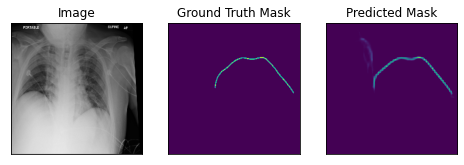

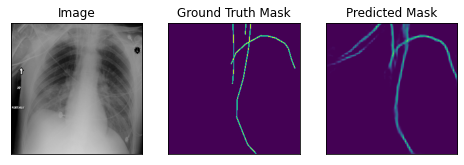

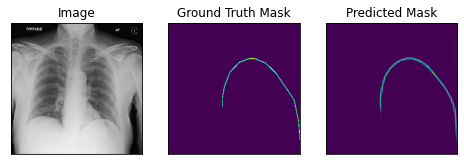

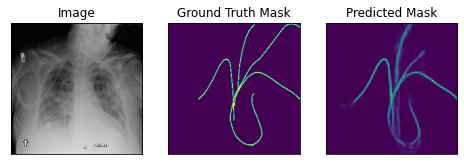

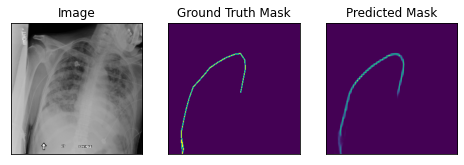

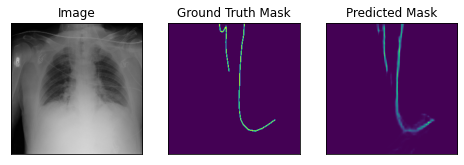

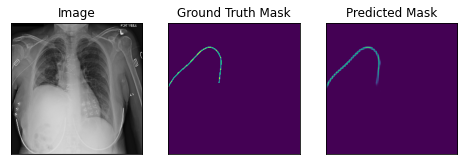

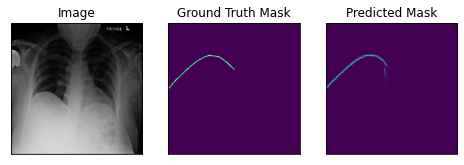

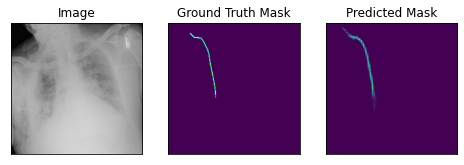

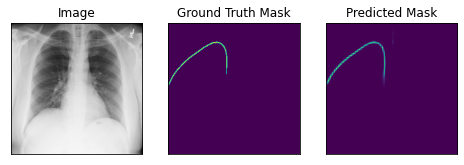

In [43]:
random = np.random.choice(X_val,10)
dataset_no_mask = XrayDataset(random, 'valid', transform=transforms_val)
with torch.no_grad():
    for i,j in enumerate(random):
        image, gt_mask = dataset_no_mask[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))).float()
        pr_mask = pr_mask.squeeze().cpu()#.round()
        #pr_mask = (sig(pr_mask).numpy()>0.6).astype(int)
    #gmask = cv2.cvtColor(np.float32(image),cv2.COLOR_BGR2RGB)
        visualize(image=image,ground_truth_mask=gt_mask,predicted_mask=pr_mask)

In [26]:
len(train_df.StudyInstanceUID.unique())-len(train_files)

20988

In [27]:
all_files = train_df.StudyInstanceUID.unique()
len(all_files)

30083

In [32]:
no_mask_files = [i for i in all_files if i not in train_files]
len(no_mask_files)

20988

In [123]:
output_dir = '../../generated_mask'
os.makedirs(output_dir, exist_ok=True)

In [124]:
len(train_files)

9095

In [ ]:
##output
#Generating annotation for the images with annotation
dataset_valid = XrayDataset(train_files, 'test', transform=transforms_val)
sig = nn.Sigmoid()
with torch.no_grad():
    for i,j in tqdm(enumerate(train_files)):
        image = dataset_valid[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))>0.5).float()
        pr_mask = pr_mask.squeeze().cpu()
        png = (pr_mask * 255)[:,:,np.newaxis]
        png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 2))], -1)
        cv2.imwrite(os.path.join(output_dir, f'{j}.png'), png)

In [ ]:
##output
#Generating the Annotation for the images without annotation
dataset_no_mask = XrayDataset(no_mask_files, 'test', transform=transforms_val)
sig = nn.Sigmoid()
with torch.no_grad():
    for i,j in tqdm(enumerate(no_mask_files),total=len(no_mask_files)):
        image = dataset_no_mask[i]
        x_tensor = image.to(device).unsqueeze(0)
        pr_mask = (sig(modelG(x_tensor))>0.5).float()
        pr_mask = pr_mask.squeeze().cpu()
        png = (pr_mask * 255)[:,:,np.newaxis]
        png = np.concatenate([png, np.zeros((png.shape[0], png.shape[1], 2))], -1)
        cv2.imwrite(os.path.join(output_dir, f'{j}.png'), png)